# Your Name Here: Zachary Yore

# A3 LogisticRegression, Multi-layer Perceptron (MLP)

## 1. Load data and perform general EDA (3+2+1+3+6 = 15pts)

### 1.1 import libraries: numpy, matplotlib.pyplot and pandas. (1+1+1 = 3pts)

You can import other libraries below as needed in any block.

In [1]:
# This jupyter notebook is prepared by “Zachary Yore”.
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import sklearn as sk

### 1.2 import the data to a pandas dataframe and show the count of rows and columns (2pts)

In [2]:
# uncomment the following line if you are running this code in google colab and have uploaded the dataset to your drive
from google.colab import files # revert back to prof way this is just temp
uploaded = files.upload()
df = pd.read_csv(r'Wine_Quality_Data.csv')
rows = len(df.axes[0])
cols = len(df.axes[1])
print("Number of rows = " + str(rows))
print("Number of cols = " + str(cols))

Saving Wine_Quality_Data.csv to Wine_Quality_Data.csv
Number of rows = 6497
Number of cols = 13


### 1.3 Show if any column has null values. (1pt)

In [3]:
df.isnull().sum().sort_values(ascending=False)
# There is no NULL data

fixed_acidity           0
volatile_acidity        0
citric_acid             0
residual_sugar          0
chlorides               0
free_sulfur_dioxide     0
total_sulfur_dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
color                   0
dtype: int64

### 1.4 We will use the 'quality' column as our target label. Print the count of each label in the dataset (in percentage). Mention which quality scores are among top 3 by their counts. (3pts)

In [4]:
df['quality'].value_counts(normalize =True)
# The top quality labels are 6,5,7 in that order

6    0.436509
5    0.329075
7    0.166077
4    0.033246
8    0.029706
3    0.004618
9    0.000770
Name: quality, dtype: float64

### 1.5 Observe the correlation matrix for the columns. Name the pairs of columns with highest positive and highest negative correlations. (2+4 = 6pts) 

You can import and use seaborn here to visualize correlation matrix in a heatmap.

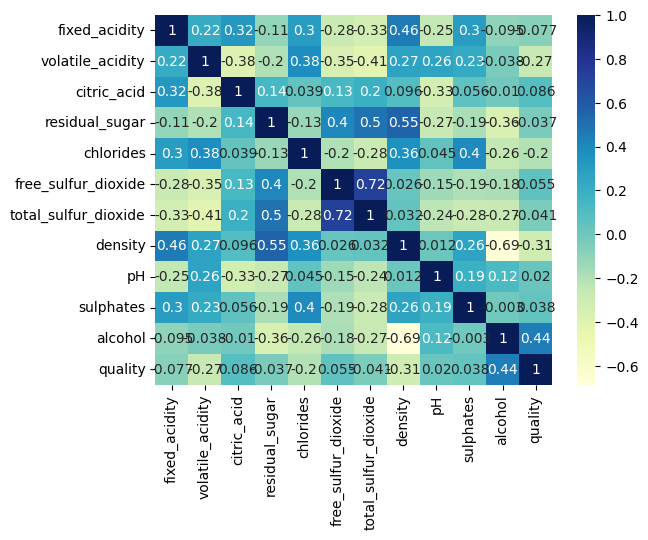

In [5]:
import seaborn as sb
dataplot = sb.heatmap(df.corr(), cmap="YlGnBu", annot=True)
# As we can see from the heat map some of the highest positve correlation columns are total_sulfur_dioxide and free_sulfur_dioxide with a .72,
# and residual_sugar and density with a score of .55. 
# Now the coumns with the most negative correlations are alchool and density with a score of -.69. Another is free_sulfur_dioxide and voliitile_acidity
# with a score of -.35

## 2. Feature Selection and Preprocessing (2+2+3+3 = 10pts)

### 2.1 Drop the 'color' attribute from the dataframe. (2pts)

In [6]:
df = df.drop(['color'], axis=1)

### 2.2 Assign the 'quality' column to target label y, and all other columns to attribute matrix X (1+1 = 2pts)

In [7]:
X = df.loc[:, df.columns != 'quality']
y = df['quality']
print(X)
print(y)

      fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
0               7.4              0.70         0.00             1.9      0.076   
1               7.8              0.88         0.00             2.6      0.098   
2               7.8              0.76         0.04             2.3      0.092   
3              11.2              0.28         0.56             1.9      0.075   
4               7.4              0.70         0.00             1.9      0.076   
...             ...               ...          ...             ...        ...   
6492            6.2              0.21         0.29             1.6      0.039   
6493            6.6              0.32         0.36             8.0      0.047   
6494            6.5              0.24         0.19             1.2      0.041   
6495            5.5              0.29         0.30             1.1      0.022   
6496            6.0              0.21         0.38             0.8      0.020   

      free_sulfur_dioxide  

### 2.3 Use scikitlearn's Standard Scaler to scale the feature matrix X. (3pts)

In [8]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

### 2.4 Split Dataset into Training and Test set. (3 pts)
Use 80:20 split for training and test. Also use stratified sampling to ensure balanced dataset.

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

## 3. Logistic Regression from scratch (10+10+10+25+20 = 75pts)


In this section, you will write a logistic regression algorithm from scratch using python and numpy. You will first write some helper functions for transforming label encoding to one-hot encoding, for measuring the cross-entropy loss and predicting labels from test data. These functions will later be used in the logistic regression training and testing.   

### 3.1 The target label in our dataset is the 'quality' column. It consists of categorical values, label-encoded with 7 values in the range [3-9]. To perform a multiclass logistic regression, you need a function that takes a label matrix and converts it to One-hot encoded labels. (10pts)

Write the function below following the docstring. 

In [10]:
def onehot(y):
    n_samples = len(y)
    n_classes = np.max(y) + 1
    onehot_matrix = np.zeros((n_samples, n_classes))
    onehot_matrix[np.arange(n_samples), y] = 1
    return onehot_matrix


### 3.2 For multi-class classification, you also need to measure cross-entropy loss. Cross-entropy loss is measured by the following formula:
$\text{Cross-Entropy Loss} = -\frac{1}{N} \sum_{i=1}^N \sum_{j=1}^n y_{ij} \log \hat{y}_{ij}$

Write a function that takes two matrices: one matrix of true labels $y_{ij}$, and one matrix of the predicted labels by your model $\hat{y}_{ij}$ (you are about to write the model function soon below), and returns the computed loss. **(10pts)**


In [11]:
def cross_entropy_loss(y_true, y_pred):
    eps = 1e-15
    y_pred = np.clip(y_pred, eps, 1 - eps)
    loss = -np.sum(y_true * np.log(y_pred)) / y_true.shape[0]
    return loss


### 3.3 Write a function for softmax activation to compute probabilities from the linear score $z_i$. Softmax function uses the following formula:
$$\sigma(z_i) = \frac{e^{z_i}}{\sum_{j=1}^{k}e^{z_j}} , \text{for } i=1,2,3,...,k $$
where $z_i$ is the linear layer score for i-th input.   

**(10pts)**

In [12]:

def softmax(scores):
    exp_scores = np.exp(scores)
    denom = np.sum(exp_scores, axis=1, keepdims=True)
    probs = exp_scores / denom
    return probs


### 3.4 Model development (20+5 = 25pts)

**3.4.1** Write a function for the logistic regression algorithm. You will use the functions you have written above in this module. Recall that with gradient descent optimization, the computation loop goes as:
For each epoch:
1. Compute $scores = X_{train} W + b$ 
2. Compute probability = softmax(scores)
3. Compute Cross-entropy Loss
4. Compute gradients of the loss with respect to the weights and bias.

    Partial derivative of Loss with respect to Weight matrix:
    $$\frac{\partial L}{\partial W} = -\frac{1}{m} X^T \left(y - \hat{y}\right)$$

    Partial derivative of Loss with respect to Bias matrix:
    $$\frac{\partial L}{\partial b_j} = -\frac{1}{m} \sum_{i=1}^m \left(y_{ij} - p_{ij}\right) $$

5. Update the weights and biases
    $$ W = W - (learning\ rate * weight\ gradient)  $$
    $$ b = b - (learning\ rate * weight\ gradient)  $$

**(20pts)**

In [13]:
def logistic_regression(X_train, y_train):
    num_samples, num_features = X_train.shape
    y_train = onehot(y_train)
    num_classes = y_train.shape[1]
    W = np.zeros((num_features, num_classes))
    b = np.zeros((1, num_classes))
    learning_rate = 0.01
    max_epochs = 1000
    loss_list = []
    for epoch in range(max_epochs):
        scores = np.dot(X_train, W) + b
        probs = softmax(scores)
        loss = cross_entropy_loss(y_train, probs)
        loss_list.append(loss)
        dW = (1 / num_samples) * np.dot(X_train.T, (probs - y_train))
        db = (1 / num_samples) * np.sum(probs - y_train, axis=0, keepdims=True)
        W -= learning_rate * dW
        b -= learning_rate * db
        if epoch % 100 == 0:
            print("Epoch {0}: loss={1}".format(epoch, loss))
    return W, b, loss_list



**3.4.2** Now that you have the model and the helper function, train the model with your prepared training dataset. Then plot the training loss curve. **(5pts)**

Epoch 0: loss=2.3025850929940455
Epoch 100: loss=2.0078326923058643
Epoch 200: loss=1.79579301646039
Epoch 300: loss=1.6465252860949862
Epoch 400: loss=1.5402321502695913
Epoch 500: loss=1.4628044011573464
Epoch 600: loss=1.4050523664815686
Epoch 700: loss=1.3609980399200474
Epoch 800: loss=1.3266713520354636
Epoch 900: loss=1.2993826154109474


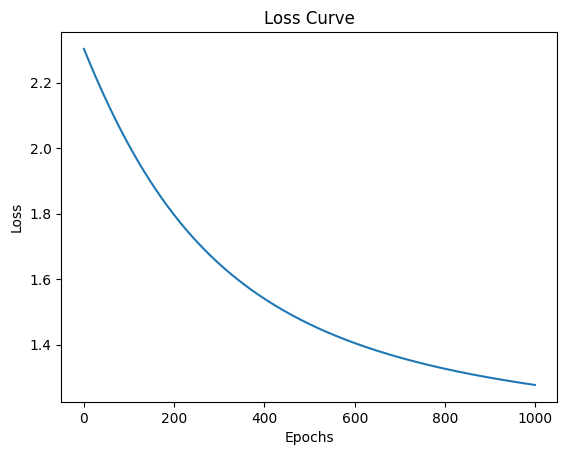

In [14]:
W, b, loss_list = logistic_regression(X_train, y_train)
plt.plot(loss_list)
plt.title("Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

### 3.5 Evaluation (10+1+4+3+2 = 20pts)

Write a function to predict the labels of X_test using the model trained above and return the predicted labels as categorical values similar to train labels. **(10pts)**

Note: By default, the predicted labels may return values within [0-6] instead of the original labels [3-9]. This can happen due to using argmax() to get label encoding from one-hot encoding when predicting test labels. You can add a simple offset to the argmax outputs of predicted labels to shift them to the range of [3-9]. This is important to note as you may see a very low accuracy even with a good model if true labels and predicted labels are not associated with the same categorical scale. 

In [15]:
def predict(X_test, W, b):
    scores = np.dot(X_test, W) + b
    probs = softmax(scores)
    preds = np.argmax(probs, axis=1)
    return preds


**3.5.1** import accuracy_score, confusion_matrix, precision_score, recall_score and f1_score from scikitlearn **(1pts)**

In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

**3.5.2** Print the prediction scores on test data in terms of accuracy, precision and recall score. **(4pts)**

In [17]:
y_pred = predict(X_test, W, b)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
print("Accuracy = ", accuracy)
print("Precision = ", precision)
print("Recall = ", precision)

Accuracy =  0.5253846153846153
Precision =  0.49090979020979025
Recall =  0.49090979020979025


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**3.5.3** Generate and visualize the confusion matrix. You can use seaborn heatmap to visualize a heatmap of the confusion matrix. **(3pts)**

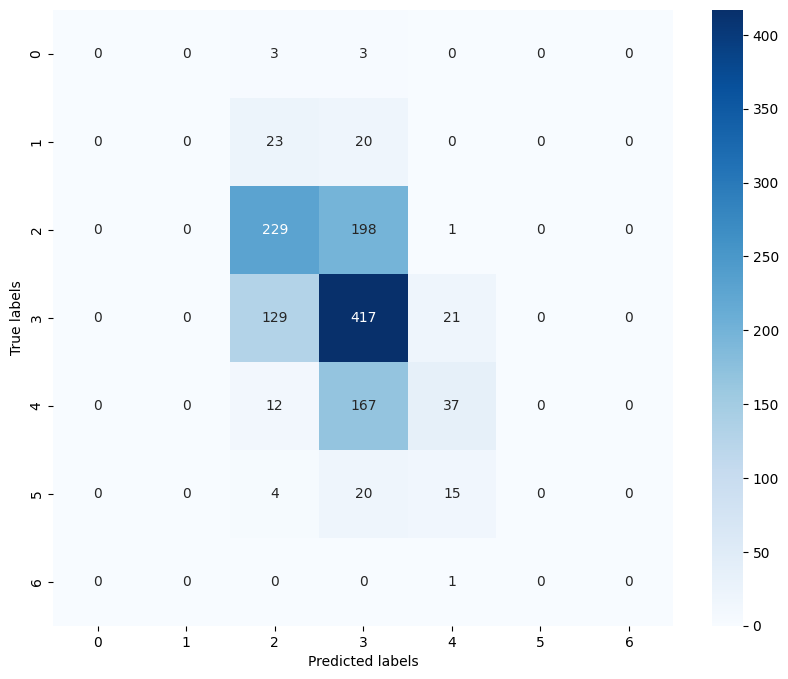

In [18]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

**3.5.4** Which labels seem to be harder to classify for this model? **(2pts)**

The labels that seem to be hardest to classify are the predicted labels 0,1,5,6 and true labels 0 and 6. As you can see from the heat maps the true labels and the predicted labels at these rows and cols barely if any correct predictions.

###

## 4. Using Scikitlearn Logistic Regression (4+2+7+2 = 15pts)

### 4.1 Import LogisticRegressionCV module and create an instance of it. (4pts)
Use the following parameters:
1. 5-fold crossvalidation, 
2. lbfgs solver, 
3. run for 1000 iterations 
4. use 'multinomial' for choosing softmax classifier  

In [19]:
from sklearn.linear_model import LogisticRegressionCV
lr_cv = LogisticRegressionCV(
    cv=5,
    solver='lbfgs',
    max_iter=1000,
    multi_class='multinomial'
)

### 4.2 Train the model and predict the labels for test set. (2pts) 

In [20]:
lr_cv.fit(X_train, y_train)
y_pred = lr_cv.predict(X_test)

/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


### 4.3 Compute the accuracy, precision, recall and F1 scores. Also visualize the confusion matrix. (1+1+1+1+3 =7pts) 

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


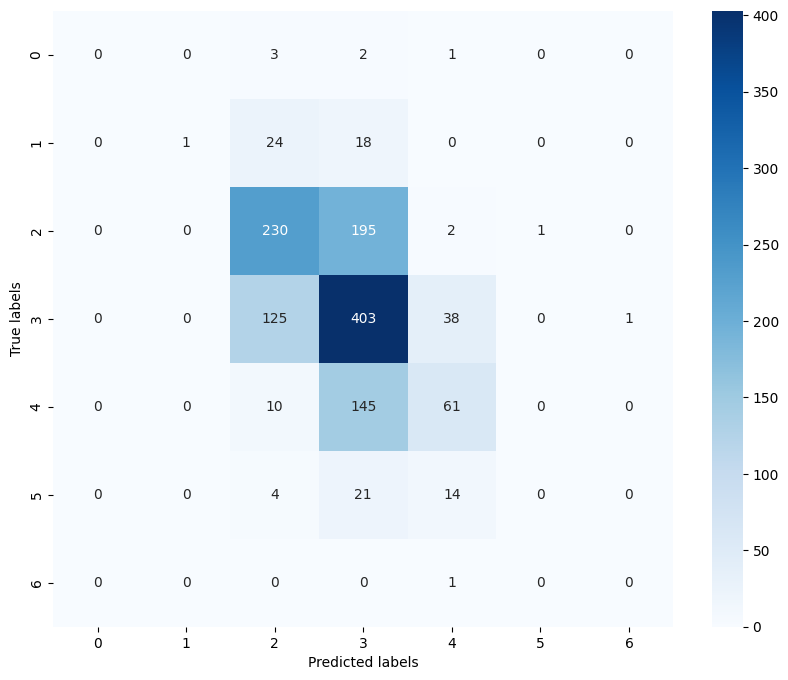

Accuracy Score =  0.5346153846153846
Precision score =  0.5351204618031542
Recall score =  0.5346153846153846
F1 score =  0.5063778072895734


In [25]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()
print("Accuracy Score = ", accuracy)
print("Precision score = ", precision)
print("Recall score = ", recall)
print("F1 score = ", f1)

### 4.4 Did your previous model (built from scratch) and the model from scikitlearn library produced similar evaluation scores? (2pts)

Explain (in <100 words) the similarity and dissimilarity in score. What changed, what didn't, and why?

As you can see from the 2 models they are very similar. In both the "built from scratch" model and the scikitlearn model they had very similar Accuracy scores. Both scoring a little above .50. Along with this the heat maps for the models are very similar. Now for the dissimilaritys the sckitlearn library produced drastically better precision and recall scores. 

## 5. Using Scikitlearn Multi-layer Perceptron (16+19 = 35pts)

### 5.1 MLP with one hidden layer and stochastic gradient descent optimizer (4+2+1+7+2 = 16pts)

**5.1.1** Import MLPClassifier from scikitlearn's neural_network library. Then create a model instance of this classifier.

Use the following parameters: 
1. One hidden layer with 100 neurons, 
2. ReLu activation, 
3. Stochastic Gradient Descent solver
4. Learning rate = 0.01 (or you can continue to use your previous learning rate)
5. No of epoch = 1000

Also, set random_state to a fixed value so that your result is reproducible. **(4pts)** 

In [26]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(100,), 
                    activation='relu', 
                    solver='sgd', 
                    learning_rate_init=0.01, 
                    max_iter=1000, random_state=42)


**5.1.2** Train the model with training set.
Then predict the labels for test set. **(2pts)**

In [27]:
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)

**5.1.3** Plot the loss curve **(1pt)**

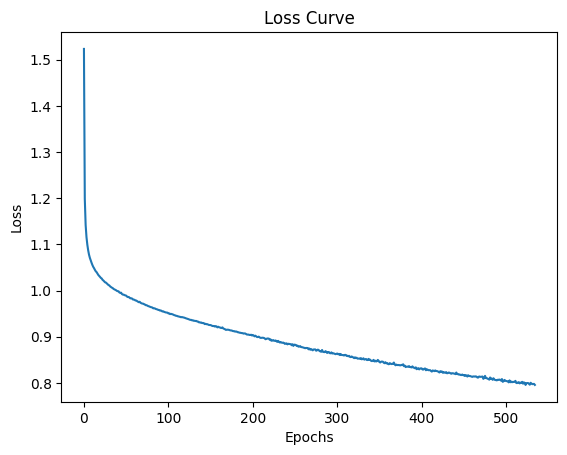

In [28]:
plt.plot(mlp.loss_curve_)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.show()

**5.1.4** Print the accuracy, precision, recall and F1 scores. Also show the confusion matrix. **(1+1+1+1+3 = 7pts)**

In [29]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)

Accuracy: 0.5615384615384615
Precision: 0.5503561827047087
Recall: 0.5615384615384615
F1 Score: 0.5441699202514731


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**5.1.5** Did you see any change in scores after using the MLP classifier?

In <100 words, describe your observation. **(2pts)**

After comparing the MLP classifier to the other 2 models the MLP classifier outperforms the other two models quite easily. The scores for the MLP classifier are all better then the other two models. 
/ # TODO

### 5.2 MLP with two hidden layer and adam optimizer (4+2+1+7+2+3 = 19pts)

**5.2.1** Import MLPClassifier from scikitlearn's neural_network library. Then create a model instance of this classifier.

Use the following parameters: 
1. **Two** hidden layers with 100 neurons, 
2. ReLu activation, 
3. Adam solver (this is an advanced optimizer which we did not cover in class. However the usage is quite straightforward)
4. Learning rate = 0.01 (or you can continue to use your previous learning rate)
5. No of epoch = 1000

Also, set random_state to a fixed value so that your result is reproducible. **(4pts)** 

(Refer to the scikitlearn documentation for clarification on the parameters)

In [30]:
mlp2 = MLPClassifier(hidden_layer_sizes=(100, 100),
                    activation='relu',
                    solver='adam',
                    learning_rate_init=0.01,
                    max_iter=1000,
                    random_state=42)

**5.2.2** Train the model with training set.
Then predict the labels for test set. **(2pts)**

In [31]:
mlp2.fit(X_train, y_train)
y_pred = mlp.predict(X_test)

**5.2.3** Plot the loss curve **(1pt)**

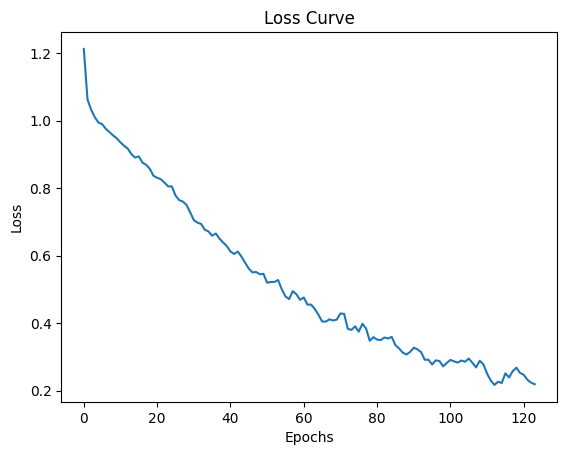

In [32]:
plt.plot(mlp2.loss_curve_)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.show()

**5.2.4** Print the accuracy, precision, recall and F1 scores. Also show the confusion matrix. **(1+1+1+1+3 = 7pts)**

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.5615384615384615
Precision: 0.5503561827047087
Recall: 0.5615384615384615
F1 Score: 0.5441699202514731


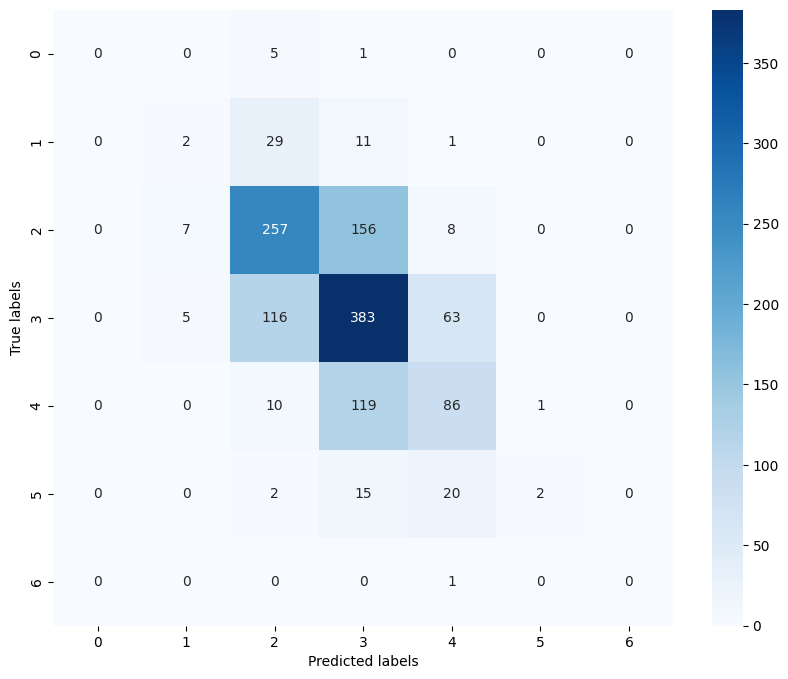

In [33]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

**5.2.5** Describe any difference in the loss curve from MLP with one hidden layer and MLP with two hidden layer. **(2pts)**

As you can comparing the two loss curves generated by using one hidden layer and 2 hidden layers. The model with 1 hidden layer drops drastically using very little epochs in the begenning while the model with 2 hidden layers is much less drastic in the begenning. 
Also the model with 2 hidden layers is alot less smoothe comparitevly with the loss curve having "ripples" through it. 

**5.2.6** Did you see any change in scores between the two MLP models?

In <100 words, describe your observation. **(3pts)**

After getting my scores from both MLP models there is no change in the scores. Even though the loss curves were different. 